In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

import matplotlib.pyplot as plt

import pathlib
import time
AUTOTUNE = tf.data.AUTOTUNE

from tf_augmentation import ds_augment
from get_model import *
from utils import *

In [2]:
data_dir = pathlib.Path("C:/Users/AORUS/dataset")

In [3]:
BATCH_SIZE = 64
IMG_SIZE = 96

REPEAT_COUNT = 30
FREEZE_EPOCHS = 25
UNFREEZE_EPOCHS = 25

FREEZE_LR = 1e-4
UNFREEZE_LR = 1e-5

In [4]:
train_ds : tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
)
val_ds : tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
)
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print(f"num: {num_classes}")
train_ds_ = train_ds.cache(str(data_dir / "train_ds")).unbatch().shuffle(len(train_ds.file_paths), reshuffle_each_iteration=True).repeat(REPEAT_COUNT)
val_ds_ = val_ds.cache(str(data_dir / "val_ds")).unbatch().shuffle(len(val_ds.file_paths), reshuffle_each_iteration=True).repeat((REPEAT_COUNT + 3) // 4)

train_ds = ds_augment(train_ds_).batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds = ds_augment(val_ds_).batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

Found 2368 files belonging to 15 classes.
Found 2368 files belonging to 15 classes.
['apple', 'banana', 'bus', 'car', 'cat', 'cow', 'dog', 'durian', 'grape', 'horse', 'orange', 'pig', 'plane', 'ship', 'train']
num: 15


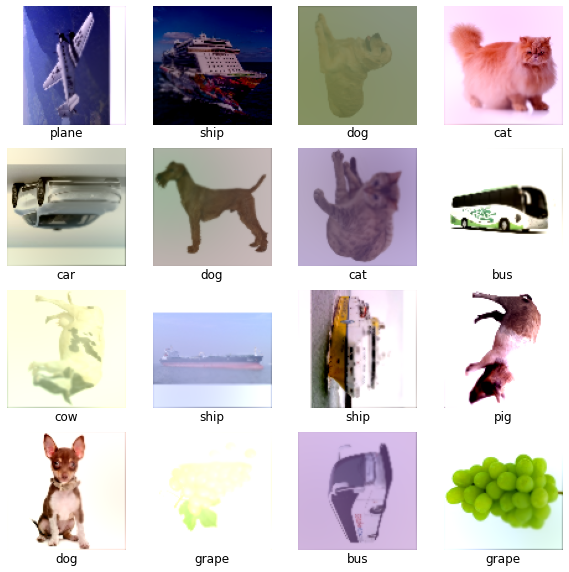

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i] / 255)
        plt.title(class_names[labels[i]], y=-0.15)
        plt.axis("off")

In [6]:
export_path = f"D:/SmartCar/TFLite_Smartcar/saved_models/{int(time.time())}"
print(export_path)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=export_path,
    save_best_only=True,
    monitor="val_loss",
    mode='min',
)

historyViewer = HistoryViewer()

D:/SmartCar/TFLite_Smartcar/saved_models/1654324846


In [7]:
base_model, model = get_EfficientNetV2B1(IMG_SIZE, num_classes, trainable=False)
model.summary()

Model: "efficientnetv2-b1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b1 (Function  (None, 3, 3, 1280)       6931124   
 al)                                                             
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
Total params: 6,950,339
Trainable params: 19,215


Epoch 1/20
1111/1111 [==============================] - 59s 45ms/step - loss: 1.2105 - accuracy: 0.6803 - val_loss: 0.5836 - val_accuracy: 0.8571
Epoch 2/20
1111/1111 [==============================] - 62s 55ms/step - loss: 0.5322 - accuracy: 0.8518 - val_loss: 0.4009 - val_accuracy: 0.8858
Epoch 3/20
1111/1111 [==============================] - 70s 62ms/step - loss: 0.4144 - accuracy: 0.8758 - val_loss: 0.3283 - val_accuracy: 0.9025
Epoch 4/20
1111/1111 [==============================] - 75s 68ms/step - loss: 0.3635 - accuracy: 0.8874 - val_loss: 0.2885 - val_accuracy: 0.9130
Epoch 5/20
1111/1111 [==============================] - 91s 82ms/step - loss: 0.3304 - accuracy: 0.8950 - val_loss: 0.2659 - val_accuracy: 0.9172
Epoch 6/20
1111/1111 [==============================] - 93s 83ms/step - loss: 0.3100 - accuracy: 0.9004 - val_loss: 0.2407 - val_accuracy: 0.9245
Epoch 7/20
1111/1111 [==============================] - 98s 88ms/step - loss: 0.2907 - accuracy: 0.9063 - val_loss: 0.2327 -

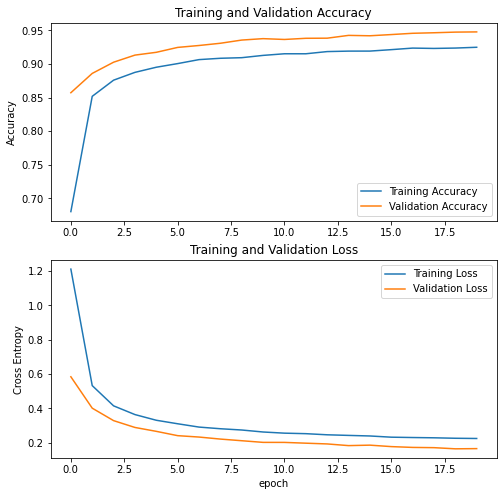

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FREEZE_LR),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    initial_epoch=0,
    epochs=FREEZE_EPOCHS,
    validation_data=val_ds,
    # callbacks=[model_checkpoint_callback],
)
historyViewer.update(history)
historyViewer.show()

In [9]:
base_model.trainable = True
model.summary()

Model: "efficientnetv2-b1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b1 (Function  (None, 3, 3, 1280)       6931124   
 al)                                                             
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
Total params: 6,950,339
Trainable params: 6,879,2

Epoch 21/40
1111/1111 [==============================] - 186s 151ms/step - loss: 0.6105 - accuracy: 0.8004 - val_loss: 0.2654 - val_accuracy: 0.9125
Epoch 22/40
1111/1111 [==============================] - 172s 155ms/step - loss: 0.3059 - accuracy: 0.8947 - val_loss: 0.1569 - val_accuracy: 0.9473
Epoch 23/40
1111/1111 [==============================] - 172s 155ms/step - loss: 0.2151 - accuracy: 0.9262 - val_loss: 0.1003 - val_accuracy: 0.9688
Epoch 24/40
1111/1111 [==============================] - 176s 158ms/step - loss: 0.1559 - accuracy: 0.9465 - val_loss: 0.0753 - val_accuracy: 0.9765
Epoch 25/40
1111/1111 [==============================] - 182s 164ms/step - loss: 0.1234 - accuracy: 0.9591 - val_loss: 0.0569 - val_accuracy: 0.9831
Epoch 26/40
1111/1111 [==============================] - 187s 168ms/step - loss: 0.1010 - accuracy: 0.9662 - val_loss: 0.0443 - val_accuracy: 0.9870
Epoch 27/40
1111/1111 [==============================] - 191s 172ms/step - loss: 0.0861 - accuracy: 0.9715

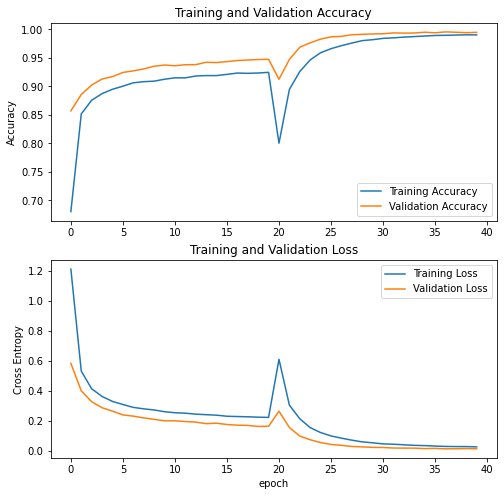

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=UNFREEZE_LR),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    initial_epoch=FREEZE_EPOCHS,
    epochs=FREEZE_EPOCHS+UNFREEZE_EPOCHS,
    validation_data=val_ds,
    # callbacks=[model_checkpoint_callback],
)
historyViewer.update(history)
historyViewer.show()

In [11]:
model.save(export_path)

INFO:tensorflow:Assets written to: D:/SmartCar/TFLite_Smartcar/saved_models/1654324846\assets


INFO:tensorflow:Assets written to: D:/SmartCar/TFLite_Smartcar/saved_models/1654324846\assets
